# Sparkmagic Demo Week 12

## Accessing Spark Cluster from Jupyter Notebook using Sparkmagic Kernel

**In contrast to the previous Spark demo from Wk 11, the following notebook has to be run in the PySpark kernel. It demonstrates:**

  - **usage of PySpark kernel to access a remote Spark cluster.**
  - **usage of Spark SQL extension.**

[Sparkmagic](https://github.com/jupyter-incubator/sparkmagic) is a *kernel extension* to Jupyter that allows to connect to a remote Spark cluster and execute Spark programs and queries directly on that cluster. It does so by introducing a new **kernel** inside Jupyter notebook, i.e. an execution environment for code included in Jupyter notebooks. This way, we can include code which is not neccessarily Python, nor has to run directly on the Jupyter server. Rather, with Sparkmagic the Spark code is sent to a [*Livy* REST server](https://livy.incubator.apache.org/get-started/) that runs directly on our Spark cluster.

![Sparkmagic Architecture](attachment:Sparkmagic%20Architecture.png "Sparkmagic Architecture")
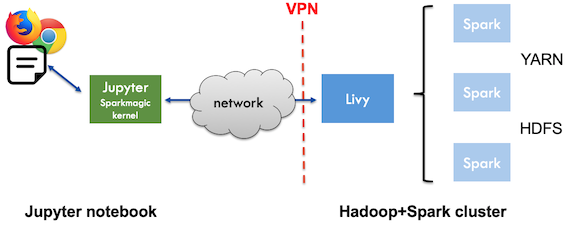

### Installation and configuration
Before you can use Sparkmagic, it has to be installed first:

 1. Installing and configuring Sparkmagic into the Jupyter server  (e.g. your notebook if you run Anaconda there)

 2. [Livy REST server](https://livy.incubator.apache.org/get-started/) on the cluster's main node (for the SIT cluster already done by us)

Regrading point (2): if you want to use Sparkmagic yourself, you need to make sure that the cluster, to which you would like to connect, has the Livy server running already. This is the case for several cloud providers, ans also for the Spark cluster of this unit of study (DATA2901). So no further action required from your side regarding point 2.

You do need to install though the Sparkmagic extensions on you Jupyter installation (note: the Jupyter servers of the School have NO SparkMagic installed). The steps of this installation are explained in the [Readme of Spark Magic](https://github.com/jupyter-incubator/sparkmagic/blob/master/README.md); in short they are (in a terminal/shell window):
 - pip install sparkmagic
 - jupyter nbextension enable --py --sys-prefix widgetsnbextension 
 - jupyter-kernelspec install sparkmagic/kernels/sparkkernel
 - jupyter-kernelspec install sparkmagic/kernels/pysparkkernel
 - jupyter serverextension enable --py sparkmagic
 - edit the config file to point to the right Livy server at:   "~/.sparkmagic/config.json"<br>
     let the `kernel_python_credentials.url` point to  `http://soit-hdp-pro-1.ucc.usyd.edu.au:8998`
     
Additionally, when executing Sparkmagic from home, you also need to install the University of Sydney VPN driver and connect to the USydney VPN.

### Using Sparkmagic's PySpark kernel
Once all this installation and configuration steps are done, a 'PySpark' kernel is now available in your Jupyter notebook which natively executes Spark code on a cluster and in addition also supports several so-called 'magic' extensions - predefined functions that are part of the kernel and which can be invoced with either '%' (for single-line statements) or '%%' (for whole-cell statements).

(note: the following steps only work when you run this notebook within a **'PySpark'** kernel).

Let's have a look at which magic commands (starting with two %% at the start of the line) are available in the PySpark kernel:

In [1]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


What do we know about the current session configuration?

In [2]:
%%info

That's the same configuration than in the previous Part 3 of the demo: 1 GB of memory for the driver and 2 executors.
Let's increase this a bit so that we can see whether a larger amount of parallelism helps with working on larger datasets. Let's double our reources and see how we do now.

You can adjust the configuration using the `%%configure -f` magic statement:

In [3]:
%%configure -f 
{"name":"LocateJT", "executorMemory": "2G", "executorCores": 4}

## Accessing data in a Spark cluster using PySpark kernel

Next, let's again look at the OnTime Performance data in the Spark cluster.
In the PySpark kernel, there is a Spark session automatically generated when needed which you can refer to with the `spark` variable. We also do not need a special '%%' command anymore to flag that a cell is referring to Spark; rather each code cell is autmatically assumed to be PySpark code. 

Using this, we again first define a new DataFrame 'flights' that represents the large-size flights data:

In [4]:
hdfspath = "soit-hdp-pro-1.ucc.usyd.edu.au/share/data3404/assignment/"

flights = spark.read.csv("hdfs://"+hdfspath+"ontimeperformance_flights_large.csv", header=True, mode="DROPMALFORMED")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
18,application_1558506097081_4531,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Note that the previous command did start a new PySpark session and that we got also told two URLs, one for the driver log, and one for the Spark UI in which we can access via a web browser the Spark driver's UI.

Let's have next a look at the start of the file:

In [5]:
flights.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(flight_id=u'5017604', carrier_code=u'UA', flight_number=u'370', flight_date=u'1994-05-01', origin=u'ORD', destination=u'PIT', tail_number=None, scheduled_depature_time=u'20:15:00', scheduled_arrival_time=u'22:32:00', actual_departure_time=u'20:19:00', actual_arrival_time=u'22:36:00', distance=u'412')

Which attributes are available in this file? Let's look at which schema Spark has inferred based on the header line of the loaded CSV file.

In [6]:
flights.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- flight_id: string (nullable = true)
 |-- carrier_code: string (nullable = true)
 |-- flight_number: string (nullable = true)
 |-- flight_date: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- tail_number: string (nullable = true)
 |-- scheduled_depature_time: string (nullable = true)
 |-- scheduled_arrival_time: string (nullable = true)
 |-- actual_departure_time: string (nullable = true)
 |-- actual_arrival_time: string (nullable = true)
 |-- distance: string (nullable = true)

How much entries are in this file? Let's count.

Note how the following command will take some time to finish, but when we check the CPU load on the local machine running this Jupyter notebook, you will see that our lcoal machine keeps idle - because this count is executed remotely inside the Spark cluster, only the result is send back.<br>
You can check for this by going to either the Spark UI (link see above) or to http://soit-hdp-pro-1.ucc.usyd.edu.au:8088/cluster and checking for the Spark application running on the cluster.

In [7]:
flights.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13051212

Great - more resources help indeed (above, we doubled to 4 cores per executor); this time the count was done in 7 seconds by Spark.

If there is any problem arising during the execution, you can check the server logs as follows:

In [8]:
%%logs

stdout: 

stderr: 
20/05/21 11:30:53 WARN SparkConf: The configuration key 'spark.yarn.jar' has been deprecated as of Spark 2.0 and may be removed in the future. Please use the new key 'spark.yarn.jars' instead.
20/05/21 11:30:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
20/05/21 11:30:55 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
20/05/21 11:30:59 WARN Client: Same path resource file:/usr/local/spark/python/lib/pyspark.zip added multiple times to distributed cache.
20/05/21 11:30:59 WARN Client: Same path resource file:/usr/local/spark/python/lib/py4j-0.10.4-src.zip added multiple times to distributed cache.

YARN Diagnostics: 

We can also execute Python code locally in this notebook *which is not send to PySpark in the Spark cluster*, but as we run in a dedicated PySpark kernel, we need now to indicate that some code is to be handled differently (meaning executed locally). This is done with the `%%local` magic:

In [9]:
%%local
test = 7 * 6
print(test)

42


### Looking for John Travolta's Boeing 707

Some celebraties are private pilots. John Travolta for example is well-known for owning his very own [Boeing 707](http://blog.flightstory.net/45/john-travoltas-boeing-707/) - a four engine former Qantas jet aircraft.

The tail number of this aircraft is well known - "N707JT" - so I wonder whether he did any flights recently?

In [10]:
counts = flights.filter(flights["tail_number"] == "N707JT") \
                .count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
print(counts)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

No matches. Perhaps the datasset was too small? Let's try the largest one:

In [ ]:
# let's check the largest file available; first define a DataFrame for this new file
all_flights = spark.read.csv("hdfs://"+hdfspath+"ontimeperformance_flights_massive.csv", header=True, mode="DROPMALFORMED")

In [ ]:
counts = all_flights.filter(all_flights["tail_number"] == "N707JT") \
                    .count()

In [ ]:
print(counts)

Doesn't look like so - but then, this would also have been quite a privacy issue if we could check in a public dataset like the Ontime dataset which flights a well-known indiviudal person would be doing...

Note also that it takes only about 32 seconds to scan and count this massive dataset (about 6GB) - which is still 4x faster than analysing the smaller data set on our local laptop in the previous demo part.

### Looking for Harrison Ford's Husky

Another known celebrity pilot is Harrison Ford. His plane is a little bit smaller than the Travolta's Boeing - a single-engine Aviat Husky A1-B. But we also know the tail number of this aircraft and he [made it recently into the news](https://www.cbsnews.com/news/harrison-ford-video-flying-airliner-california-airport/) by landing, by mistake, on John Wayne Airport near L.A. on the taxi way rather than the runway...

Let's first see whether we have data about ohn Wayne International Airport - its IATA code is "SNA":

In [ ]:
# checking flights from John Wayne Airport
# John Wayne, also known by IATA (International Air Transport Association) code SNA 
# and ICAO (International Civil Aviation Organization) code KSNA
countsJW = all_flights.filter(all_flights["destination"] == "SNA") \
                      .count()
print(countsJW)

Yes, there is flight data for this airport - over half a million flights in the large dataset.
Now let's check whether Ford's Husky (tail number N6HY) is included:

In [ ]:
countsHusky = all_flights.filter(all_flights["tail_number"] == "N6HY").count()
print(countsHusky)

Ok, seems we also have no information about Harrison Ford's Husky in the data set. This is acually a good thing - this data set should be about general commercial flights by major airlines and not about private flights by individuals, where we otherwise could derive some insights about personal travel patterns. This is luckily not possible with this data set.

### Visualising data analysis results with Spark+Python

We can use a local Python execution cell to visualise results which we computed in the Spark cluster.
For example, the following uses Spark to aggregate of all flights at Hohn Wayne airport near L.A. per time of the day (using internal functions by Spark to extyract the hour of a timestamp and to group). We then visualise this result in a *local* Python cell using matplotlib:

In [ ]:
# analyse number of flights per year at John Wayne Airport in the cluster
countsJWperHoD = all_flights.filter(all_flights["destination"] == "SNA") \
                            .groupBy(hour("flight_date").alias("hour_of_day"))  \
                            .count()

In [ ]:
%%local
%matplotlib inline
import matplotlib
# visualise locally
countsJWperHoD.plot()

## Demo: Spark SQL

Spark also allows to query its datasets using SQL.

To do so, we first need to (at least temporary) create an SQL "view" of the dataset which we would like to access using SQL:

In [13]:
all_flights.createOrReplaceTempView("Flights")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

From now on, we can use `spark.sql()` calls to use standard SQL queries to analyse this view. For example, which date range does this large data set actually cover?

In [14]:
sqlResult = spark.sql("SELECT MIN(flight_date), MAX(flight_date), COUNT(flight_id) FROM Flights")
sqlResult

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[min(flight_date): string, max(flight_date): string, count(flight_id): bigint]

In [15]:
sqlResult.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------------+----------------+
|min(flight_date)|max(flight_date)|count(flight_id)|
+----------------+----------------+----------------+
|      1994-01-01|      2008-12-31|        13051212|
+----------------+----------------+----------------+

Ok how many flights are recorded per each year?

In [16]:
sqlResult = spark.sql("SELECT YEAR(flight_date) AS Year, MIN(flight_date), MAX(flight_date), COUNT(flight_id)\
                         FROM Flights \
                        GROUP BY YEAR(flight_date) \
                        ORDER BY YEAR(flight_date)")
sqlResult.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------------+----------------+----------------+
|Year|min(flight_date)|max(flight_date)|count(flight_id)|
+----+----------------+----------------+----------------+
|1994|      1994-01-01|      1994-12-31|          845255|
|1995|      1995-01-01|      1995-12-31|          897947|
|1996|      1996-01-01|      1996-12-31|          911908|
|1997|      1997-01-01|      1997-12-31|          924766|
|1998|      1998-01-01|      1998-12-31|          924077|
|1999|      1999-01-01|      1999-05-31|          347241|
|2000|      2000-01-01|      2000-12-31|          959071|
|2003|      2003-01-01|      2003-12-31|         1124100|
|2004|      2004-01-01|      2004-12-31|         1200847|
|2005|      2005-01-01|      2005-12-31|         1186557|
|2006|      2006-01-01|      2006-12-31|         1243552|
|2007|      2007-01-01|      2007-12-31|         1273792|
|2008|      2008-01-01|      2008-12-31|         1212099|
+----+----------------+----------------+----------------+

We also can use SQL queries directly on DataFrames using the `%%sql` magic:

In [ ]:
%%sql
show tables

Let's run an SQL query directly on the 'Flights' temporary table; note how the result view afterwards is now interactive, allowing us to switch between a table view and different graphical visualisations of the result too.

In [ ]:
%%sql
SELECT YEAR(flight_date) AS Year, MIN(flight_date), MAX(flight_date), COUNT(flight_id) 
  FROM Flights
 GROUP BY YEAR(flight_date)
 ORDER BY Year

### Last step: cleanup and clearing any Spark sessions

In [18]:
%%cleanup -f

# End of Demo